# ML_3Type
establish a 3 type classifier for SE/E/NE data, according to SZa, CLa, LAa and 3 '_Err'  
'effc': 0=SE; 1=E; 2=NE  
NE(>0.7), E(0.7~0.3), SE(<0.3)

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition as skldec
import numpy as np
import seaborn as sns
import time
import os

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

save_dir = 'input your file dir' #r'E:\Github'

# Function

In [2]:
from sklearn.model_selection import GridSearchCV

def GridSearch_result(ML, X, y, param_grid, cv=3, score="accuracy"):
    start = time.time()
    grid_search = GridSearchCV(ML, param_grid, cv=cv, scoring=score, refit=True)
    grid_search.fit(X, y)
    end = time.time()
    print("Run Time:%s s" % (end-start))
    return [grid_search.best_params_, grid_search.best_estimator_]

In [126]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score  #AUC

def ML_result(ML, X, y, label, roc=0, feedback=0, save_dir=None,
              cmap=sns.color_palette('tab10'), cv=3, ifprint=False):
    "Input: ML classifier. "
    "fit, and Output confusion_matrix, accuracy_score / roc_curve"
    
    #ML.fit(X, y)
    y_pred = cross_val_predict(ML, X, y, cv=cv)
    
    conf_mat = confusion_matrix(y, y_pred)
    accu = accuracy_score(y, y_pred)
    if roc != 0:
        if roc == "rf":
            y_probas_forest = cross_val_predict(ML, X, y, cv=cv, method="predict_proba")
            y_scores = y_probas_forest[:, 1] # score = proba of positive class
        if roc == "sgd":
            y_scores = cross_val_predict(ML, X, y, cv=cv, method="decision_function")
        fpr, tpr, thresholds = roc_curve(y, y_scores)
        auc = roc_auc_score(y, y_scores)
        plot_roc_curve([fpr], [tpr], label=[label], auc=[auc], cmap=cmap, save_dir=save_dir)
        plt.show()
        if feedback == 1:
            return {"conf_mat":conf_mat, "accu":accu, "auc":auc, "fpr":fpr, "tpr":tpr}
        else:
            return {"conf_mat":conf_mat, "accu":accu, "auc":auc}
    if ifprint == True:
        print({"conf_mat":conf_mat, "accu":accu})
    return {"conf_mat":conf_mat, "accu":accu}

In [318]:
def conf_mat_heatmap(conf_mat, rect_set, title, ticklabel=['SE','E','NE'], 
                     cmap=None, density=True, save_dir=None,):
    'draw conf_matrix heatmap'
    fig = plt.figure(dpi=130, figsize=(2.5, 2.5)) 
    ax1 = fig.add_subplot(111)
    density_mat = conf_mat / np.sum(conf_mat, axis=1).reshape(conf_mat.shape[0], -1)
    
    if cmap == None:  #return matplotlib colormap
        cmap = sns.cubehelix_palette(rot=0.2, gamma=0.5, dark=0.3, light=1, as_cmap=True)#violet
    if density == False: #annotation show raw number
        h = sns.heatmap(data=density_mat, xticklabels=ticklabel, yticklabels=ticklabel, 
                        vmin=0, vmax=1, annot=conf_mat, mask=density_mat==0,
                        linewidths=1, linecolor="0.7", cbar=False, #turn off color bar
                        annot_kws={'size':12,'color':"k",'family':"Arial"}, #'weight':600,
                        square=True, cmap=cmap, ax=ax1)
    elif density == True:
        h = sns.heatmap(data=density_mat, xticklabels=ticklabel, yticklabels=ticklabel, 
                        vmin=0, vmax=1, annot=True, fmt=".1%", mask=density_mat==0,
                        linewidths=1, linecolor="0.7", cbar=False,
                        annot_kws={'size':11,'color':"k",'family':"Arial",}, 
                        square=True, cmap=cmap, ax=ax1)
    ax1.tick_params(width=2, length=4, colors="k")
    rect = plt.Rectangle(xy=rect_set["xy1"], width=rect_set["width1"], height=rect_set["height1"],
                         fill=False, edgecolor="k", linewidth=rect_set["linewidth1"])
    ax1.add_patch(rect)
    
    rect_cb = [1, 0.13, 0.11, 0.74] # color bar
    cbar_ax = fig.add_axes(rect_cb)
    cb = h.figure.colorbar(h.collections[0], cax=cbar_ax) #show colorbar
    cb.ax.tick_params(direction='out', labelsize=9, length=4, width=1, colors="k",
                      right=True)#left=True, 
    rect2 = plt.Rectangle(xy=rect_set["xy2"], width=rect_set["width2"], height=rect_set["height2"],
                         fill=False, edgecolor="k", linewidth=rect_set["linewidth2"] )
    cbar_ax.add_patch(rect2)
    font1 = {'family':'Arial', 'color':'k', 'weight':'bold', 'size': 12}
    accu = conf_mat.trace()/conf_mat.sum()
    ax1.set_xlabel('Accuracy Score:{:.1%}'.format(accu), font1);
    ax1.set_ylabel("Actual", font1);
    ax1.set_title(str(title)+'\n Predicted', font1); 
    if save_dir != None:
        plt.savefig(os.path.join(save_dir, title+'.png'), bbox_inches='tight', dpi=150)
        
rect_set={"xy1":(0.015,0.017), "width1":1.96, "height1":1.96,"linewidth1":2.2,
                    "xy2":(0.03,0.004), "width2":0.97, "height2":0.99,"linewidth2":1.1}
rect_set2={"xy1":(0.023,0.017), "width1":2.94, "height1":2.96,"linewidth1":2.2,
                    "xy2":(0.03,0.004), "width2":0.97, "height2":0.99,"linewidth2":1.1}
cmap2=sns.cubehelix_palette(start=2.75, rot=0, gamma=1, hue=2, dark=0.5, light=1, as_cmap=True)#blue
cmap3=sns.cubehelix_palette(start=0.8, rot=0, gamma=0.9, hue=1.2, dark=0.5, light=1, as_cmap=True)#bricks

# import data

In [343]:
file_path = os.path.join(save_dir,'ML_dataset.xlsx')
df = pd.read_excel(file_path, sheet_name='adj_effc_3t', index_col=0)  
df.dropna(inplace=True)
df.head()

,cancer,sample_id,LAa,LAErr,SZa,SZErr,CLa,CLErr,effc,kill
id,,,,,,,,,,
81,CCom,A3,1.51085,0.13405,1.34627,0.02986,1.83637,0.22148,2,0.30000
16,GC,5,1.03143,0.22530,1.20558,0.06233,0.82232,0.09236,2,0.07000
60,KC,A6,0.11333,0.01206,1.15431,0.10533,0.02664,0.00668,0,0.97336
37,PaC,6,0.81366,0.01794,1.14430,0.09914,0.97903,0.07454,2,0.00000
90,GC,A2,1.71732,0.40495,1.12907,0.01176,1.44957,0.08896,2,0.04000


In [4]:
#split data
df3 = df.loc[:, ["LAa","LAErr","SZa","SZErr","CLa","CLErr"]]
df3.head()

,LAa,LAErr,SZa,SZErr,CLa,CLErr
id,,,,,,
81,1.51085,0.13405,1.34627,0.02986,1.83637,0.22148
16,1.03143,0.22530,1.20558,0.06233,0.82232,0.09236
60,0.11333,0.01206,1.15431,0.10533,0.02664,0.00668
37,0.81366,0.01794,1.14430,0.09914,0.97903,0.07454
90,1.71732,0.40495,1.12907,0.01176,1.44957,0.08896


# Visualization

In [5]:
index3 = ["CLa","LAa","SZa","CLErr","LAErr","SZErr","effc"]
df_c = df.loc[:, index3]
corr_matrix = df_c.corr()
corr_matrix["effc"].sort_values(ascending=False)

effc     1.000000
CLa      0.796878
LAa      0.730532
SZa      0.615968
CLErr    0.441411
LAErr    0.267801
SZErr    0.216525
Name: effc, dtype: float64

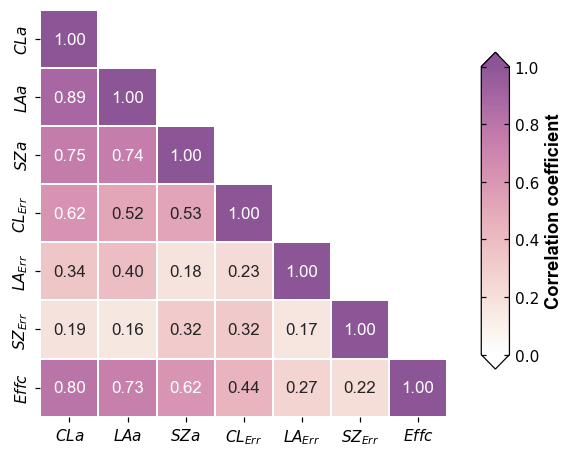

In [11]:
fig = plt.figure(dpi=110, )
ax1 = fig.add_subplot(111)
cmap = sns.cubehelix_palette(rot=0.4, hue=0.9, gamma=0.7, dark=0.3, light=1, as_cmap=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), 1)
g=sns.heatmap(data=corr_matrix, vmax=1, vmin=0, linewidth=1, linecolor="w", cmap=cmap,
              annot = True, fmt="0.2f", square=True, mask=mask, cbar=False,
              ax=ax1, annot_kws={'size':11, 'family':"Arial"},)

rect = [0.85, 0.2, 0.04, 0.6]   #x, y, x_width, y_height
cbar_ax = fig.add_axes(rect)
cb = g.figure.colorbar(g.collections[0], cax=cbar_ax, extend="both")  #share colorbar
cb.ax.tick_params(direction='in', color="k", length=3, left=True, right=True)
cb.set_label('Correlation coefficient', font={'family':'Arial', 'size':12, 'weight': 'bold'})
labels = ['$CLa$','$LAa$','$SZa$','$CL_{Err}$','$LA_{Err}$','$SZ_{Err}$',"$Effc$"]
ax1.set_yticklabels(labels);
ax1.set_xticklabels(labels);
#fig.savefig(os.path.join(save_dir, str(time.time())+'.png'), dpi=150, bbox_inches='tight')

In [97]:
#PCA
pca = skldec.PCA()
pca.fit(df3)
result = pca.transform(df3)

data = pd.DataFrame(result)
data['label'] = np.array(df.effc)
data

,0,1,2,3,4,5,label
0,1.716002,0.035878,0.096184,-0.075637,0.030290,0.066523,2
1,0.693676,0.447050,-0.164975,0.000187,0.155484,0.054385,2
2,-0.382791,0.994978,0.081704,-0.052080,0.068707,-0.002045,0
3,0.644134,0.411908,0.115701,-0.068697,-0.004609,-0.032591,2
4,1.459682,-0.078248,-0.342719,0.014896,0.255272,0.043671,2
...,...,...,...,...,...,...,...
89,-0.932429,-0.016139,0.000975,-0.049787,-0.014419,0.018728,0
90,-0.917494,-0.027223,0.025770,-0.043373,0.002811,0.022065,0
91,-0.941914,-0.014663,0.013553,-0.044438,0.003312,0.022242,0
92,-0.968697,-0.001484,0.049589,-0.049317,0.004837,0.020648,0


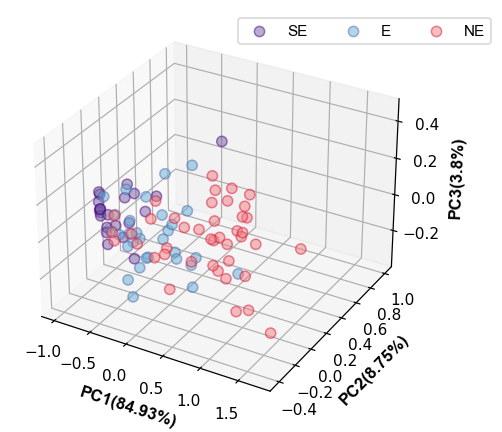

In [100]:
#3D scatter
fig_a = plt.figure(dpi=110)
ax = fig_a.add_subplot(111, projection='3d')
d1 = data.loc[data['label']==0] #SE
d2 = data.loc[data['label']==1] #E
d3 = data.loc[data['label']==2] #NE

ax.scatter(d1.iloc[:, 0], d1.iloc[:, 1], d1.iloc[:, 2], c="#765EA3", alpha=0.5, 
           edgecolor="indigo", s=45, label='SE')
ax.scatter(d2.iloc[:, 0], d2.iloc[:, 1], d2.iloc[:, 2], c="#64ADD9", alpha=0.5, 
           edgecolor="#4F6AAA", s=45, label='E')
ax.scatter(d3.iloc[:, 0], d3.iloc[:, 1], d3.iloc[:, 2], c="lightcoral", alpha=0.5, 
           edgecolor="crimson", s=45, label='NE')

x_label = 'PC1(%s%%)' % round(pca.explained_variance_ratio_[0]*100.0, 2);
y_label = 'PC2(%s%%)' % round(pca.explained_variance_ratio_[1]*100.0, 2);
z_label = 'PC3(%s%%)' % round(pca.explained_variance_ratio_[2]*100.0, 2);
font1 = {'family':'Arial', 'size':11, "color":"k", 'weight':'bold',}
ax.legend(bbox_to_anchor=(1.2, 1), ncol=3, prop={"size":10, 'family':'Arial'})
ax.tick_params(labelsize=10, color="k")
ax.set_xlabel(x_label, font1)
ax.set_ylabel(y_label, font1)
ax.set_zlabel(z_label, font1)
plt.show()
fig_a.savefig(os.path.join(save_dir, str(time.time())+'.png'), dpi=150, )

In [54]:
def plot_sig(xstart, xend, ystart, yend, sig, ax, vert=True):
    '''
    to draw significance markers *
    sig: list. Control the shape of these annotation
    vert: bool. whether draw vertical line.
    '''
    for i in range(len(xstart)):
        if vert[i] == True:
            x = np.ones((2)) * xstart[i]
            y = np.arange(ystart[i], yend[i]+0.1, yend[i]-ystart[i])
            ax.plot(x, y, label="$y$", linewidth=1, color="0.3")
            x = np.ones((2))*xend[i]
            y = np.arange(ystart[i], yend[i]+0.1, yend[i]-ystart[i])
            ax.plot(x, y, label="$y$", linewidth=1, color="0.3")

        x = np.arange(xstart[i], xend[i]+0.1, xend[i]-xstart[i])#draw horizontal line
        y = yend[i] + 0*x
        ax.plot(x, y, label="$y$", linewidth=2, color="0.3")

        x0 = (xstart[i] + xend[i])/2
        y0=yend[i]
        ax.annotate(r'%s'% sig[i], xy=(x0, y0),   # %s string 
                     fontsize=10, fontweight="bold", fontfamily="Microsoft YaHei",
                    color="0.3", va="baseline", ha="center") 
    plt.show()

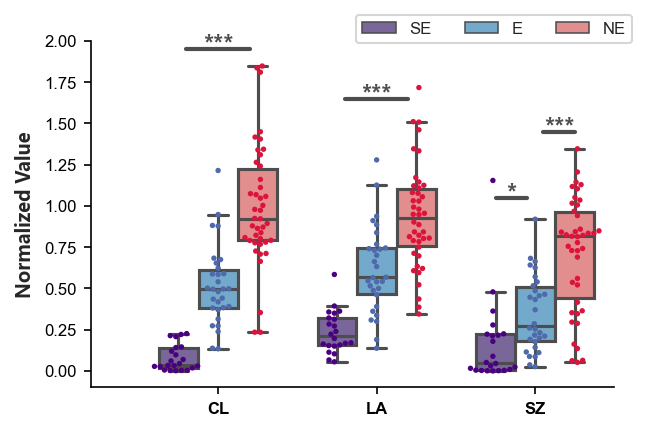

In [342]:
#boxplot
df4 = pd.read_excel(os.path.join(save_dir,'boxplot.xlsx'),
                   sheet_name="kill_adj_3t", index_col=0)
fig = plt.figure(figsize=(4.5,3), dpi=150)
ax1 = fig.add_subplot(111)

c1 = ["#765EA3", "#64ADD9", "lightcoral"]
c2 = ["indigo", "#4F6AAA", "crimson"]
a = sns.boxplot(x="Attri", y="val", hue="effc", dodge=True, #dots won't overlap 
                data=df4, ax=ax1, showfliers=False, #Don't display outliers
                linewidth=1.5, width=0.75, palette=c1);
b = sns.swarmplot(x="Attri", y="val", hue="effc", data=df4,  palette=c2,
                  size=2.6, dodge=True, ax=ax1);

handles = ax1.get_legend_handles_labels()
ax1.legend(handles = handles[0][0:3], bbox_to_anchor=(1.05, 1.1), ncol=3,
           labels=["SE","E","NE"], prop={"size":8},)
plt.ylabel("Normalized Value", fontsize=9, fontweight="600", fontfamily="Microsoft YaHei")
plt.xlabel(None)
ax1.set_xticklabels(["CL","LA","SZ"], fontweight="600", fontfamily="Arial")
plt.tick_params(axis='both', direction='out', labelsize=8)
plt.ylim(-0.1,2)
plt.xlim(-0.8,2.5)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plot_sig([-0.2, 0.8, 1.75, 2.05], [0.2, 1.2, 1.95, 2.25], [1.7, 1.5,1.5, 1.8], [1.95, 1.65, 1.05, 1.45],
         ['***','***','*','***'], ax1, [0, 0, 0, 0])

fig.savefig(os.path.join(save_dir, str(time.time())+'.png'), dpi=200, bbox_inches='tight')

# SE/E/NE ML classifier
for multiple classification task, automatically run One-versus-All (OvA) strategy

## data process & Visualization
use average to fill nan. 1-CLa as kill if kill == nan

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit

def split_train_test(dataframe, dataframe_y, test_size=0.2, random_state=42):
    split = StratifiedShuffleSplit(test_size=test_size, random_state=random_state)
    for train_index, test_index in split.split(dataframe, dataframe_y):
        train_set = dataframe.iloc[train_index]
        test_set = dataframe.iloc[test_index]
    return train_set, test_set

In [344]:
start_train_set, start_test_set = split_train_test(df, df["effc"])
start_train_set.head()

,cancer,sample_id,LAa,LAErr,SZa,SZErr,CLa,CLErr,effc,kill
id,,,,,,,,,,
34,STS,A7,0.78969,0.00890,0.77784,0.11739,1.24140,0.11865,2,0.00000
46,GCa,A3,0.35725,0.02128,0.08857,0.03031,0.22092,0.01727,0,0.77908
61,KC,A7,0.82205,0.06581,1.11752,0.08848,0.87915,0.04157,2,0.12085
98,BCp,A3,1.12507,0.03723,0.72970,0.14415,1.04687,0.15024,2,0.21000
120,BCh,A8,0.84253,0.18808,0.28831,0.00454,0.89369,0.09183,2,0.24000


In [345]:
index3 = ["LAa","LAErr","SZa","SZErr","CLa","CLErr","effc"]
train_set_3 = start_train_set.loc[:, index3]
test_set_3 = start_test_set.loc[:, index3]
train_set_3.head()

,LAa,LAErr,SZa,SZErr,CLa,CLErr,effc
id,,,,,,,
34,0.78969,0.00890,0.77784,0.11739,1.24140,0.11865,2
46,0.35725,0.02128,0.08857,0.03031,0.22092,0.01727,0
61,0.82205,0.06581,1.11752,0.08848,0.87915,0.04157,2
98,1.12507,0.03723,0.72970,0.14415,1.04687,0.15024,2
120,0.84253,0.18808,0.28831,0.00454,0.89369,0.09183,2


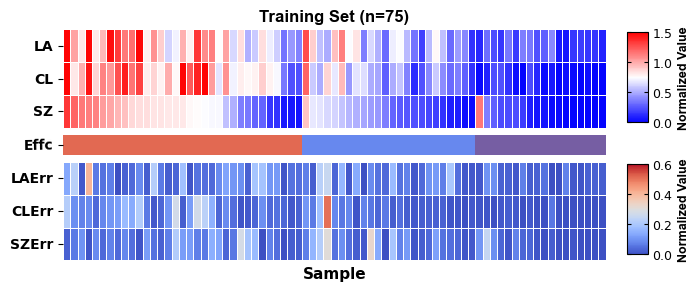

In [94]:
fig = plt.figure(dpi=100, figsize=(7,3))
grid = fig.add_gridspec(3, 1, hspace=0.1, height_ratios=[4,0.8,4])
ax1 = plt.subplot(grid[0,:])
ax2 = plt.subplot(grid[2,:])
ax0 = plt.subplot(grid[1,:])
############## heatmap123
data=train_set_3.sort_values(by = ['effc',"SZa"], ascending=False)
h=sns.heatmap(data=data[["LAa","CLa","SZa"]].T, 
            ax=ax1,
            vmin=0,vmax=1.5,
            linewidth=0.7,
            linecolor="w",
            cmap=sns.color_palette('bwr',n_colors=100),
            cbar=False,
            cbar_kws={ 'label': 'Normalized Value',
                      'extend':'both',},
           )
g=sns.heatmap(data=data[["LAErr","CLErr","SZErr"]].T, 
            ax=ax2,
            linewidth=0.7,
            vmin=0, vmax=0.6,
            linecolor="w",
            cmap=sns.color_palette('coolwarm',n_colors=100), 
            cbar=False
           )
cmap1 = ["#765EA3", sns.color_palette('coolwarm')[0], sns.color_palette('coolwarm')[-1]]
sns.heatmap(data=np.array(data["effc"]).reshape(1,-1), ax=ax0,
            linewidth=0, linecolor="w", cmap=cmap1, cbar=False,
           )
ax0.set_xlabel(None) 
ax0.set_xticks([]);
ax0.set_yticklabels(["Effc"], rotation=1, fontweight="bold")
############ cbar
rect = [0.93, 0.57, 0.03, 0.3] 
cbar_ax = fig.add_axes(rect)
cb = h.figure.colorbar(h.collections[0], cax=cbar_ax) 
cb.ax.tick_params(direction='in', labelsize=9, color="k", length=3,
                  left=True, right=True) 
font1 = {'family': 'Arial', 
         'weight': 'bold',
         'size':9}
cb.ax.set_ylabel( 'Normalized Value', font1)
###################
rect2 = [0.93, 0.13, 0.03, 0.3]
cbar_ax2 = fig.add_axes(rect2)
cb2 = g.figure.colorbar(g.collections[0], cax=cbar_ax2)
cb2.ax.tick_params(direction='in', labelsize=9, color="k", length=3,
                  left=True,right=True)
cb2.ax.set_ylabel( 'Normalized Value', font1)
################### set axis
font2 = {'family': 'Arial', 
         'weight': 'bold',}
ax1.set_title("Training Set (n=%s)" % train_set_3.shape[0], font2);
ax1.set_yticklabels(["LA","CL","SZ"], fontweight="bold", rotation=0)
ax2.set_yticklabels(["LAErr","CLErr","SZErr"], fontweight="bold")
ax1.set_xlabel(None) 
ax2.set_xlabel("Sample", fontweight="bold", fontsize=11) 
ax1.set_xticks([]);
ax2.set_xticks([]);

fig.savefig(os.path.join(save_dir, str(time.time())+'.svg'), bbox_inches='tight', dpi=150)

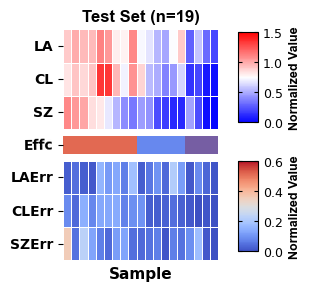

In [95]:
fig = plt.figure(dpi=100, figsize=(2,3))
grid = fig.add_gridspec(3, 1, hspace=0.1, height_ratios=[4,0.7,4])
ax1 = plt.subplot(grid[0,:])
ax2 = plt.subplot(grid[2,:])
ax0 = plt.subplot(grid[1,:])
############## heatmap123
data = test_set_3.sort_values(by = ['effc',"SZa"], ascending=False)
h=sns.heatmap(data=data[["LAa","CLa","SZa"]].T, 
            ax=ax1,
            vmin=0,vmax=1.5,
            linewidth=0.7,
            linecolor="w",
            cmap=sns.color_palette('bwr',n_colors=100),
            cbar=False,
            cbar_kws={ 'label': 'Normalized Value',
                      'extend':'both',},
           )
g=sns.heatmap(data=data[["LAErr","CLErr","SZErr"]].T, 
            ax=ax2,
            linewidth=0.7,
            vmin=0,vmax=0.6,
            linecolor="w",
            cmap=sns.color_palette('coolwarm',n_colors=100),
            cbar=False
           )
cmap1 = ["#765EA3", sns.color_palette('coolwarm')[0], sns.color_palette('coolwarm')[-1]]
sns.heatmap(data=np.array(data["effc"]).reshape(1,-1), ax=ax0,
            linewidth=0, linecolor="w", cmap=cmap1, cbar=False,
           )
ax0.set_xlabel(None) 
ax0.set_xticks([]);
ax0.set_yticklabels(["Effc"], rotation=1, fontweight="bold")
############ cbar
rect = [1, 0.57, 0.1, 0.3] 
cbar_ax = fig.add_axes(rect)
cb = h.figure.colorbar(h.collections[0], cax=cbar_ax) 
cb.ax.tick_params(direction='in', labelsize=9, color="k", length=3,
                  left=True, right=True) 
font1 = {'family': 'Arial', 
         'weight': 'bold',
         'size':9}
cb.ax.set_ylabel( 'Normalized Value', font1)
###################
rect2 = [1, 0.14, 0.1, 0.3] 
cbar_ax2 = fig.add_axes(rect2)
cb2 = g.figure.colorbar(g.collections[0], cax=cbar_ax2) 
cb2.ax.tick_params(direction='in', labelsize=9, color="k", length=3,
                  left=True, right=True)  
cb2.ax.set_ylabel( 'Normalized Value', font1)
################### set axis
font2 = {'family': 'Arial',
            'color': 'k',
            'weight': 'bold',
            }
ax1.set_title("Test Set (n=%s)" % test_set_3.shape[0], font2);
ax1.set_yticklabels(["LA","CL","SZ"], fontweight="bold", rotation=0)
ax2.set_yticklabels(["LAErr","CLErr","SZErr"], fontweight="bold")
ax1.set_xlabel(None) 
ax2.set_xlabel("Sample", fontweight="bold", fontsize=11) 
ax1.set_xticks([]);
ax2.set_xticks([]); 

fig.savefig(os.path.join(save_dir, str(time.time())+'.svg'), bbox_inches='tight', dpi=150)

In [33]:
def num_cat(dataframe, column="effc"):
    data_num = dataframe.drop(column, axis=1)
    list_cat = dataframe[column].tolist()
    data_cat = np.array(list_cat)
    return data_num, data_cat

In [34]:
X_train, y_train = num_cat(train_set_3, column="effc")
X_test, y_test = num_cat(test_set_3, column="effc")

## Model Training
3 algorithms: SGD, RF, SVM. mulitmode (=3) data  

### without parameter tuning

#### SGD

{'conf_mat': array([[18,  0,  0],
       [ 5,  1, 18],
       [ 3,  0, 30]], dtype=int64), 'accu': 0.6533333333333333}


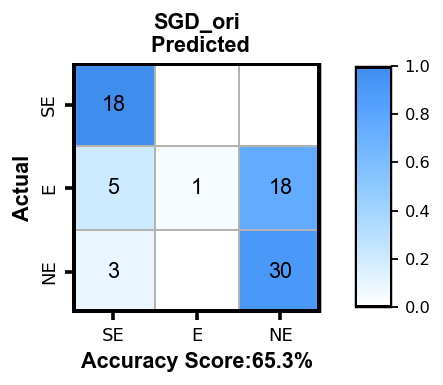

In [203]:
sgd_clf = SGDClassifier(random_state=42)
r_s = ML_result(sgd_clf, X_train, y_train, "SGD_ori", cv=3, ifprint=1)

conf_mat_heatmap(r_s['conf_mat'], rect_set=rect_set2, title="SGD_ori", density=0,
                cmap=cmap2, save_dir=save_dir)

#### RF

{'conf_mat': array([[17,  1,  0],
       [ 3, 14,  7],
       [ 0,  5, 28]], dtype=int64), 'accu': 0.7866666666666666}


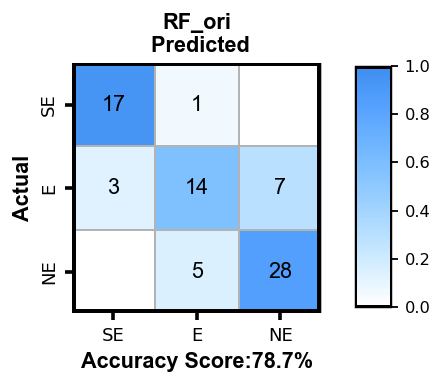

In [204]:
forest_clf = RandomForestClassifier(random_state=42)
r_f = ML_result(forest_clf, X_train, y_train, "RF_ori", cv=3, ifprint=1)

conf_mat_heatmap(r_f['conf_mat'], rect_set=rect_set2, title="RF_ori", density=0,
                cmap=cmap2, save_dir=save_dir)

#### SVM
SVM was originally designed for binary classification. When dealing with multi-class problems, it's necessary to construct suitable classifiers: 'ovr' one-versus-rest / 'ovo' one-versus-one

{'conf_mat': array([[17,  1,  0],
       [ 3, 14,  7],
       [ 0,  5, 28]], dtype=int64), 'accu': 0.7866666666666666}


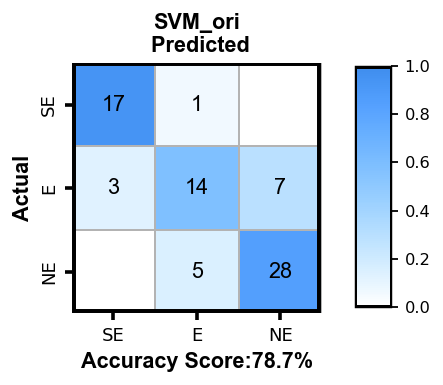

In [205]:
svc_1 = SVC(probability=True, random_state=42, decision_function_shape="ovr")
r_c = ML_result(forest_clf, X_train, y_train, "SVM_ori", cv=3, ifprint=1)

conf_mat_heatmap(r_c['conf_mat'], rect_set=rect_set2, title="SVM_ori", density=0,
                cmap=cmap2, save_dir=save_dir)

### GridSearch
triple modal data

#### SGD
best_SGDClassifier(eta0=0.36, learning_rate='constant', loss='log', n_jobs=-1,
              random_state=42)

In [31]:
sgd_clf = SGDClassifier(random_state=42,n_jobs=-1)
param=[{"learning_rate": ['constant','optimal','invscaling'], 'penalty': ['l2','l1','elasticnet'], 
         "loss":["hinge","modified_huber","log"], "eta0":np.linspace(0.25,0.45,num=21),
         "class_weight":[None,"balanced"], 
       }]
sgdbest = GridSearch_result(sgd_clf, X_train, y_train, param)
print(sgdbest)
r_sgd3=ML_result(sgdbest[1], X_train, y_train, "SGD",roc=0)
print(r_sgd3['conf_mat'],r_sgd3['accu'])

Run Time:443.56542468070984 s
[{'class_weight': None, 'eta0': 0.36, 'learning_rate': 'constant', 'loss': 'log', 'penalty': 'l2'}, SGDClassifier(eta0=0.36, learning_rate='constant', loss='log', n_jobs=-1,
              random_state=42)]
[[18  0  0]
 [ 3 13  8]
 [ 0  3 30]] 0.8133333333333334


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


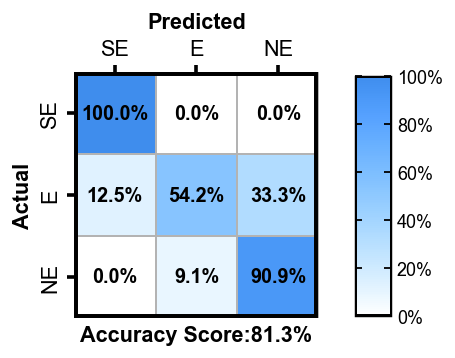

In [34]:
conf_mat_heatmap(r_sgd3['conf_mat'], rect_set=rect_set2, title="SDG", density=0,
                save_dir=save_dir)

#### SVM
best_SVC(C=1.2, degree=1, gamma='auto', probability=True, random_state=42)]

In [36]:
svc_clf = SVC(probability=True, random_state=42)
param3 = [{'kernel':["rbf","poly","linear"], "C":[0.8, 0.9, 1, 1.1, 1.2, 1.3],
           "degree":[1,2,3,4,5], "class_weight":[None,"balanced"],
          "gamma":["auto",1/7,1/6,1/8,1/9], }]
svcbest = GridSearch_result(svc_clf, X_train, y_train, param3,)
print(svcbest)
r_svm3=ML_result(svcbest[1], X_train, y_train, "svc", roc=0)
print(r_svm3['conf_mat'], r_svm3['accu'])

Run Time:33.97535467147827 s
[{'C': 1.2, 'class_weight': None, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}, SVC(C=1.2, degree=1, gamma='auto', probability=True, random_state=42)]
[[17  1  0]
 [ 4 14  6]
 [ 1  5 27]] 0.7733333333333333


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


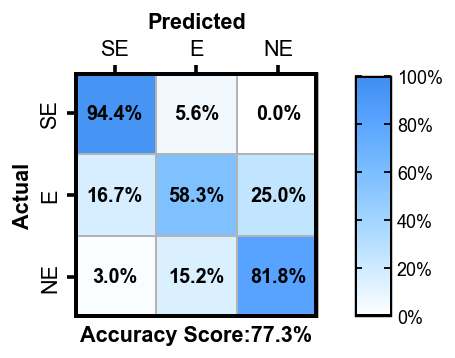

In [37]:
conf_mat_heatmap(r_svm3['conf_mat'], rect_set=rect_set2, title="SVM", density=0,
                save_dir=save_dir)

#### RF
best_RandomForestClassifier(max_depth=2, max_features=6, n_estimators=9, n_jobs=-1,
                       random_state=42)

In [84]:
forest_clf = RandomForestClassifier(n_jobs=-1,random_state=42,)
param2 = [{'n_estimators': range(2,18), "max_depth":[None,2,3,4,5], "max_features":["auto",6,5],
          }]
rfbest = GridSearch_result(forest_clf, X_train, y_train, param2,)
print(rfbest)
r_rf3 = ML_result(rfbest[1], X_train, y_train, "RF", roc=0)
print(r_rf3['conf_mat'], r_rf3['accu'])

Run Time:99.9494776725769 s
[{'max_depth': 2, 'max_features': 6, 'n_estimators': 9}, RandomForestClassifier(max_depth=2, max_features=6, n_estimators=9, n_jobs=-1,
                       random_state=42)]
[[17  1  0]
 [ 2 19  3]
 [ 0  4 29]] 0.8666666666666667


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


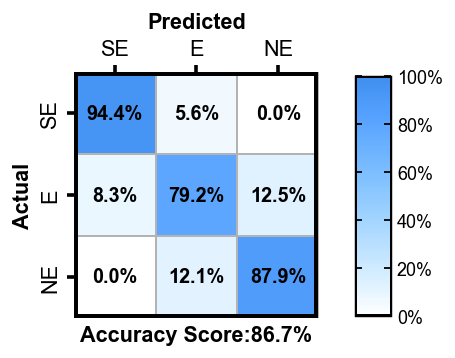

In [18]:
conf_mat_heatmap(r_rf3['conf_mat'], rect_set=rect_set2, title="RF", density=0,
                save_dir=save_dir)

## Dual-mode data
### LA+SZ

#### SGD
best_SGDClassifier(eta0=1.03, learning_rate='constant', loss='log', n_jobs=-1,
              penalty='l1', random_state=42)

In [47]:
#ori
sgd_clf3 = SGDClassifier(random_state=42, n_jobs=-1)
index4 = ["LAa","LAErr","SZa","SZErr"]
ML_result(sgd_clf3, X_train[index4], y_train, "SGD_2atri" )

{'conf_mat': array([[11,  5,  2],
        [ 4,  7, 13],
        [ 2,  8, 23]], dtype=int64),
 'accu': 0.5466666666666666}

In [80]:
sgd_clf_lasz = SGDClassifier(random_state=42, n_jobs=-1)

param=[{"learning_rate": ['constant','optimal','invscaling'], 'penalty': ['l2','l1','elasticnet'], 
        "eta0":np.linspace(0.9,1.1,num=21), "loss":["hinge","modified_huber","log"], 
        "class_weight":[None,"balanced"],
       }]
sgdbest_lasz = GridSearch_result(sgd_clf_lasz, X_train[index4], y_train, param, )
print(sgdbest_lasz)
r_s_lasz=ML_result(sgdbest_lasz[1], X_train[index4], y_train, "SGD_lasz",roc=0)
print(r_s_lasz['conf_mat'],r_s_lasz['accu'])

Run Time:375.6672716140747 s
[{'class_weight': None, 'eta0': 1.03, 'learning_rate': 'constant', 'loss': 'log', 'penalty': 'l1'}, SGDClassifier(eta0=1.03, learning_rate='constant', loss='log', n_jobs=-1,
              penalty='l1', random_state=42)]
[[15  3  0]
 [ 4 16  4]
 [ 2  6 25]] 0.7466666666666667


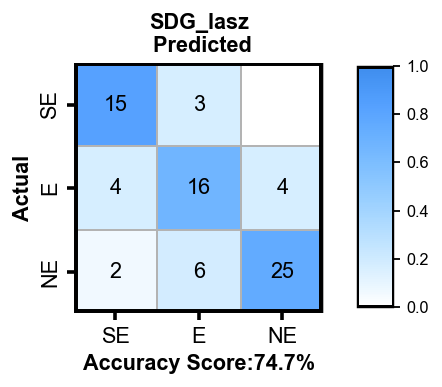

In [221]:
conf_mat_heatmap(r_s_lasz['conf_mat'], rect_set=rect_set2, title="SDG_lasz", 
                 density=0, save_dir=save_dir)

#### RF
best_RandomForestClassifier(max_depth=3, max_features=4, n_estimators=5, n_jobs=-1,
                       random_state=42)

In [83]:
forest_clf_lasz = RandomForestClassifier(random_state=42, n_jobs=-1)
param2 = [{'n_estimators': range(2,18), "max_depth":[None,3,4,5], 
          "max_features":["auto",3,4,2],}]
rfbest_lasz = GridSearch_result(forest_clf_lasz, X_train[index4], y_train, param2,)
print(rfbest_lasz)
r_f_lasz=ML_result(rfbest_lasz[1], X_train[index4], y_train,"RF_lasz", roc=0)
print(r_f_lasz['conf_mat'],r_f_lasz['accu'])

Run Time:113.5271201133728 s
[{'max_depth': 3, 'max_features': 4, 'n_estimators': 5}, RandomForestClassifier(max_depth=3, max_features=4, n_estimators=5, n_jobs=-1,
                       random_state=42)]
[[15  2  1]
 [ 5 10  9]
 [ 1  5 27]] 0.6933333333333334


#### SVM
best_SVC(C=0.7, degree=1, gamma='auto', kernel='linear', probability=True,
    random_state=42)]

In [82]:
svc_lasz = SVC(probability=True,random_state=42)
param3 = [{'C':[0.8,0.9,1.0,0.7,0.5,0.6], "class_weight":[None,"balanced"], 
           "gamma":["auto",1/10,1/9,1/11,1/8,1/7], "degree":[1,2,3,4],
           "kernel":['linear',"poly","rbf",],
          }]
svcbest_lasz = GridSearch_result(svc_lasz, X_train[index4], y_train, param3,)
print(svcbest_lasz)
r_v_lasz=ML_result(svcbest_lasz[1], X_train[index4], y_train, "SVM_lasz", roc=0)
print(r_v_lasz['conf_mat'],r_v_lasz['accu'])

Run Time:11.591997861862183 s
[{'C': 0.7, 'class_weight': None, 'degree': 1, 'gamma': 'auto', 'kernel': 'linear'}, SVC(C=0.7, degree=1, gamma='auto', kernel='linear', probability=True,
    random_state=42)]
[[15  2  1]
 [ 4 14  6]
 [ 2  8 23]] 0.6933333333333334


### LA+CL
#### RF
best_RandomForestClassifier(max_depth=3, max_features=3, n_estimators=13, n_jobs=-1,
                       random_state=42)]

In [87]:
index6=["LAa","LAErr","CLa","CLErr"]
forest_clf_lacl = RandomForestClassifier(n_jobs=-1, random_state=42)
param2 = [{'n_estimators': range(2,20), "max_depth":[None,2,3,4], 
           "max_features":["auto",3,4,2],
          }]
rfbest_lacl = GridSearch_result(forest_clf_lacl, X_train[index6], y_train, param2,)
print(rfbest_lacl)
r_f_lacl=ML_result(rfbest_lacl[1], X_train[index6], y_train,"RF_lacl", roc=0)
print(r_f_lacl['conf_mat'],r_f_lacl['accu'])

Run Time:123.95243310928345 s
[{'max_depth': 3, 'max_features': 3, 'n_estimators': 13}, RandomForestClassifier(max_depth=3, max_features=3, n_estimators=13, n_jobs=-1,
                       random_state=42)]
[[15  2  1]
 [ 5 10  9]
 [ 1  5 27]] 0.6933333333333334


#### SDG
best_SGDClassifier(class_weight='balanced', eta0=0.31, learning_rate='constant',
              loss='log', n_jobs=-1, random_state=42)

In [98]:
sgd_clf_lacl = SGDClassifier(random_state=42,n_jobs=-1)

param=[{"learning_rate":['constant','optimal','invscaling'], 
        "eta0":np.linspace(0.2,0.4,num=21), "loss":["hinge","modified_huber","log"], 
         'penalty': ['l2','l1','elasticnet'], "class_weight":[None,"balanced"], 
       }]
sgdbest_lacl = GridSearch_result(sgd_clf_lacl, X_train[index6], y_train, param, )
print(sgdbest_lacl)
r_s_lacl=ML_result(sgdbest_lacl[1], X_train[index6], y_train, "SGD_lacl",roc=0)
print(r_s_lacl['conf_mat'],r_s_lacl['accu'])

Run Time:376.61925411224365 s
[{'class_weight': 'balanced', 'eta0': 0.31, 'learning_rate': 'constant', 'loss': 'log', 'penalty': 'l2'}, SGDClassifier(class_weight='balanced', eta0=0.31, learning_rate='constant',
              loss='log', n_jobs=-1, random_state=42)]
[[18  0  0]
 [ 5 14  5]
 [ 2  1 30]] 0.8266666666666667


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


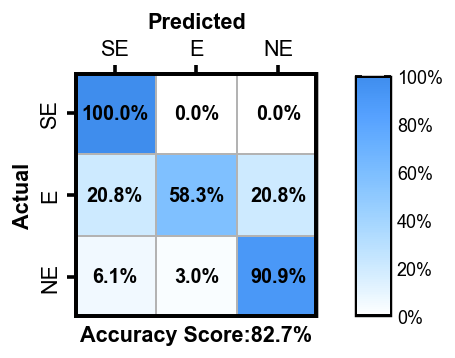

In [120]:
conf_mat_heatmap(r_s_lacl['conf_mat'], rect_set=rect_set2, title="SDG_lacl", 
                 density=0, cmap=cmap2, save_dir=save_dir)

### SZ+CL
#### SGD
best_SGDClassifier(eta0=0.22, learning_rate='constant', loss='log', n_jobs=-1,
              random_state=42)]

In [99]:
#ori
sgd_clf_clsz = SGDClassifier(random_state=42)
ML_result(sgd_clf_clsz, X_train[index5], y_train, "clsz-ori")

{'conf_mat': array([[18,  0,  0],
        [ 4,  7, 13],
        [ 1,  3, 29]], dtype=int64),
 'accu': 0.72}

In [100]:
index5 = ["CLa","CLErr","SZa","SZErr"]
sgd_clf_szcl = SGDClassifier(random_state=42,n_jobs=-1)

param=[{"learning_rate":['constant','optimal','invscaling'], 
        "eta0":np.linspace(0.2,0.4,num=11), "loss":["hinge","modified_huber","log"],
         'penalty':['l2','l1','elasticnet'], "class_weight":[None,"balanced"], 
       }]
sgdbest_szcl = GridSearch_result(sgd_clf_szcl, X_train[index5], y_train, param, )
print(sgdbest_szcl)
r_s_clsz=ML_result(sgdbest_szcl[1], X_train[index5], y_train, "SGD_szcl",roc=0)
print(r_s_clsz['conf_mat'], r_s_lasz['accu'])

Run Time:197.00132203102112 s
[{'class_weight': None, 'eta0': 0.22, 'learning_rate': 'constant', 'loss': 'log', 'penalty': 'l2'}, SGDClassifier(eta0=0.22, learning_rate='constant', loss='log', n_jobs=-1,
              random_state=42)]
[[18  0  0]
 [ 3 12  9]
 [ 2  1 30]] 0.8


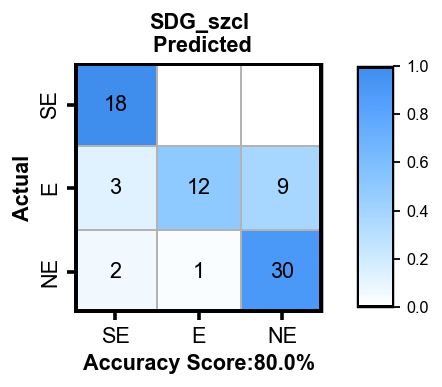

In [329]:
conf_mat_heatmap(r_s_clsz['conf_mat'], rect_set=rect_set2, title="SDG_szcl", 
                 density=0, cmap=cmap2, save_dir=save_dir)

#### RF
best_RandomForestClassifier(max_features=4, n_estimators=12, n_jobs=-1,
                       random_state=42)]

In [101]:
#ori
forest_clf_clsz = RandomForestClassifier(random_state=42)
ML_result(forest_clf_clsz, X_train[index5], y_train,"clsz_ori")

{'conf_mat': array([[16,  2,  0],
        [ 3, 18,  3],
        [ 0,  3, 30]], dtype=int64),
 'accu': 0.8533333333333334}

In [90]:
forest_clf_szcl = RandomForestClassifier(n_jobs=-1,random_state=42)
param2 = [{'n_estimators': range(2,20), "max_depth":[None,2,3,4], 
           "max_features":["auto",3,4,2],  }]
rfbest_szcl = GridSearch_result(forest_clf_szcl, X_train[index5], y_train, param2,)
print(rfbest_szcl)
r_f_szcl=ML_result(rfbest_szcl[1], X_train[index5], y_train,"RF_szcl", roc=0)
print(r_f_szcl['conf_mat'], r_f_szcl['accu'])

Run Time:126.29723453521729 s
[{'max_depth': None, 'max_features': 4, 'n_estimators': 12}, RandomForestClassifier(max_features=4, n_estimators=12, n_jobs=-1,
                       random_state=42)]
[[17  1  0]
 [ 2 18  4]
 [ 0  2 31]] 0.88


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


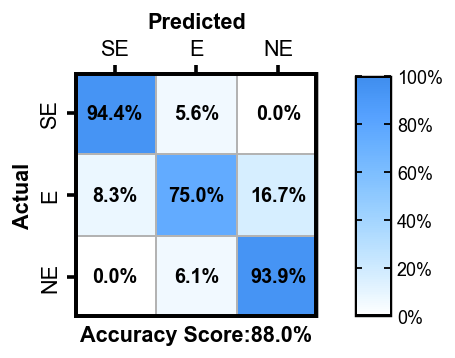

In [17]:
conf_mat_heatmap(r_f_szcl['conf_mat'], rect_set=rect_set2, title="RF_szcl", density=0, 
                 cmap=cmap2, save_dir=save_dir)

#### re_draw

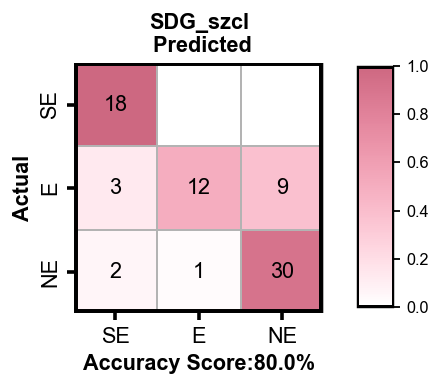

In [332]:
x=np.array([[18 , 0 , 0],
 [ 3, 12,  9],
 [ 2,  1 ,30]])
conf_mat_heatmap(x, rect_set=rect_set2, title="SDG_szcl", density=0, 
                 cmap=cmap3, save_dir=save_dir)

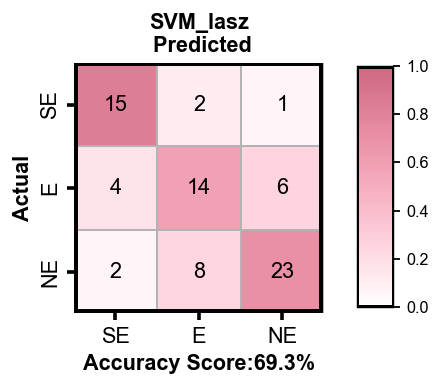

In [322]:
x=np.array([[15,  2 , 1],
 [ 4, 14 , 6],
 [ 2 , 8 ,23]])
conf_mat_heatmap(x, rect_set=rect_set2, title="SVM_lasz", density=0, 
                 cmap=cmap3, save_dir=save_dir)

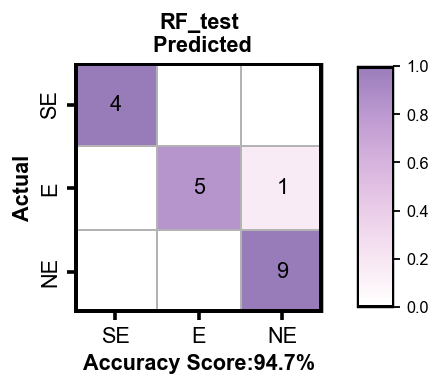

In [ ]:
x=np.array([[4 ,0 ,0],
 [0, 5, 1],
 [0 ,0 ,9]])
conf_mat_heatmap(x, rect_set=rect_set2, title="RF_test", density=0, 
                 cmap=None, save_dir=save_dir)

## on Test Set
### triple modal

In [341]:
final_pred=sgdbest[1].predict(X_test)
conf_test=confusion_matrix(y_test, final_pred)
print(conf_test)

[[3 1 0]
 [0 5 1]
 [0 0 9]]


D:\Anaconda\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [340]:
final_pred=svcbest[1].predict(X_test)
conf_test=confusion_matrix(y_test, final_pred)
print(conf_test)

[[3 1 0]
 [0 5 1]
 [0 1 8]]


In [106]:
final_pred_rf=rfbest[1].predict(X_test.values)
conf_test=confusion_matrix(y_test, final_pred_rf)
print(conf_test)

[[4 0 0]
 [0 5 1]
 [0 0 9]]


D:\Anaconda\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


### cl / szcl

In [108]:
#sgd_clf_cl.fit(X_train[["CLa","CLErr"]], y_train)
final_pred_c=rfbest_cl[1].predict(X_test[["CLa","CLErr"]])
conf_test_c=confusion_matrix(y_test, final_pred_c)
print(conf_test_c)

[[4 0 0]
 [0 5 1]
 [0 0 9]]


In [109]:
final_pred_szcl=rfbest_szcl[1].predict(X_test[index5])
conf_test_szcl=confusion_matrix(y_test, final_pred_szcl)
print(conf_test_szcl)

[[4 0 0]
 [0 5 1]
 [0 0 9]]
